# Regularización en redes neuronales

### Procesamiento de Lenguaje Natural

**Pablo Martínez Olmos, Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


## 1. Clasificación de imágenes. Fashion-MNIST

En este segundo notebook, utilizaremos la base de datos de imágenes [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST es un conjunto de imágenes de ropa en escala de grises de 28x28 clasificadas en 10 categorías. La base de datos es suficientemente compleja como para que una MLP no encuentra una buena solución en términos de generalización en datos de test y acabe sobreajustando. En este notebook mostraremos cómo controlar el sobreajuste con *early stopping* y *dropout*.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

### 1.2 Descarga de FMNIST con `torchvision`

La base de datos puedes descargarse de forma sencilla a través del paquete `torchvision`. El [torchvision] (https://pytorch.org/docs/stable/torchvision/index.html) proporciona datasets de uso común, arquitecturas de modelos y transformaciones de imágenes comunes para aplicaciones de visión por ordenador.

El siguiente código descargará el conjunto de datos FMNIST y luego creará conjuntos de datos de entrenamiento y test. 

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Hemos cargado nuestros datos en una clase de tipo [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) llamada `trainloader` y que convertimos en un iterador con` iter(trainloader) `. 

Vamos a echar un vistazo a un mini-batch de datos y representar una muestra.


In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Podemos ver cómo hay 10 categorías distintas

In [5]:
print(labels)

tensor([5, 9, 8, 0, 8, 2, 2, 3, 4, 4, 6, 3, 1, 2, 4, 4, 2, 2, 9, 8, 3, 4, 2, 6,
        1, 5, 8, 3, 9, 9, 6, 5, 4, 6, 7, 6, 4, 3, 0, 2, 8, 6, 0, 5, 3, 0, 6, 9,
        9, 5, 4, 0, 3, 0, 1, 5, 8, 3, 8, 9, 9, 8, 2, 2])


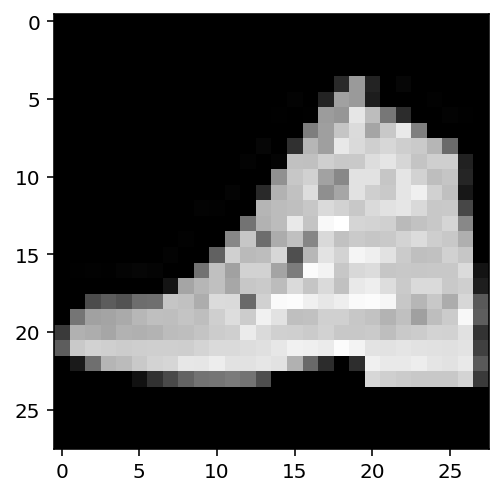

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## 2. Visualizando el sobreajuste. Early stopping

En el siguiente código definimos una red MLP con cuatro capas, dimensiones ocultas 256, 128 y 64 neuronas, y activaciones en las capas intermedias de tipo ReLU. Como ahora tenemos un clasificador multi-clase
utilizaremos una *softmax* para calcular las probabilidades de clase. En el código que se proporciona, se usa `nn.LogSoftmax` en lugar de `nn.Softmax ()`, que devuelve el **logaritmo** de la probabilidad de clase. 
La función de coste de la entropía cruzada se obtiene combinando `nn.LogSoftmax` con la función de coste *negative log-likelihood* ` nn.NLLLoss () `.


In [7]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels=10): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) #Con dim=1 indicamos que cada fila a la salida de la función de activación suma 1                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x) 
        return x

Extendemos la clase añadiendo método de entrenamiento. Esta clase es muy parecida a la del notebook anterior, con dos pequeñas diferencias:
* Reemplazamos la función de coste, ahora usamos `nn.NLLLoss()`
* Ahora usamos [Adam](https://ruder.io/optimizing-gradient-descent/) como optimizador
* Iteramos sobre trainloader

In [8]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #Reiniciamos gradientes
            
                out = self.forward(images.view(images.shape[0], -1))

                #Función de coste en el batch
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Calculamos gradientes
                loss.backward()
                
                #Una iteración de descenso por gradiente
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Entrenemos la red ...

In [9]:
my_MLP = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader)

Training loss after 0 epochs: 0.513049
Training loss after 1 epochs: 0.375419
Training loss after 2 epochs: 0.339843
Training loss after 3 epochs: 0.311389
Training loss after 4 epochs: 0.290537
Training loss after 5 epochs: 0.277551
Training loss after 6 epochs: 0.261097
Training loss after 7 epochs: 0.249228
Training loss after 8 epochs: 0.240044
Training loss after 9 epochs: 0.230584
Training loss after 10 epochs: 0.221320
Training loss after 11 epochs: 0.209247
Training loss after 12 epochs: 0.203041
Training loss after 13 epochs: 0.195021
Training loss after 14 epochs: 0.186505
Training loss after 15 epochs: 0.179800
Training loss after 16 epochs: 0.172602
Training loss after 17 epochs: 0.163485
Training loss after 18 epochs: 0.158384
Training loss after 19 epochs: 0.152309
Training loss after 20 epochs: 0.145330
Training loss after 21 epochs: 0.142786
Training loss after 22 epochs: 0.136770
Training loss after 23 epochs: 0.131378
Training loss after 24 epochs: 0.125439
Training l

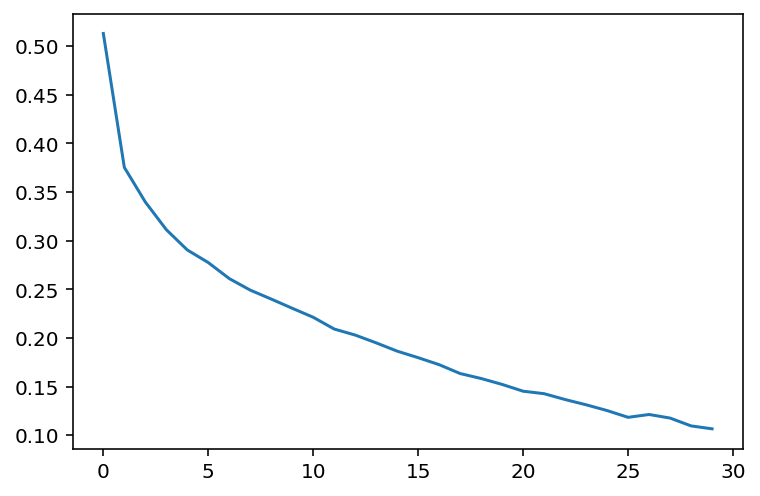

In [10]:
plt.plot(my_MLP.loss_during_training)

Usamos la siguiente función para calcular el porcentaje de etiquetas correctas en train/test. Observad que hacemos el cálculo por mini-batches ...

In [11]:
from sklearn.metrics import accuracy_score

def accuracy(dataloader,model):

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        accuracy = 0.
            
        for images,labels in dataloader:
            
            logprobs = model.forward(images.view(images.shape[0], -1)).detach().numpy()
            
            prediction = np.argmax(logprobs,1)
            
            accuracy += accuracy_score(labels.numpy(),prediction,normalize=True)
        
        return accuracy/len(dataloader)

In [12]:
print(f"Train accuracy {accuracy(trainloader,my_MLP)}")
print(f"Test accuracy {accuracy(testloader,my_MLP)}")

Train accuracy 0.9565398454157783
Test accuracy 0.8793789808917197


A la luz de los resultados anteriores, ciertamente el modelo se está desempeñando significativamente mejor en el conjunto de entrenamiento que en el conjunto de test. Este es un signo de sobreajuste. Para una detección temprana del sobreajuste, haremos uso de un **conjunto de validación** que usaremos para visualizar la evolución de la función de pérdida durante el entrenamiento y así implementar early stopping.

Con el siguiente código, dividimos el conjunto de trenes en un conjunto de entrenamiento (de 45k imágenes) y un conjunto de validación (de 15k imágenes)


In [ ]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]


> **Ejercicio**: Complete el código de la siguiente  clase, en la que modificamos la clase `MLP_extended` anterior para que, durante el entrenamiento, cada vez que termine una época, calcule la función de pérdida sobre el conjunto de validación. Debe almacenar estos valores en un nombre de lista como `valid_loss_during_training`. Al realizar este paso, no olvide apagar los gradientes usando `with torch.no_grad()`.
>
> Luego, repita el entrenamiento (30 épocas) y dibuje la evolución de la función de coste en entrenamiento y validación.

In [ ]:
class MLP_extended2(MLP):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
    
    
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #Reiniciamos gradientes
            
                out = self.forward(images.view(images.shape[0], -1))

                #Función de coste en el batch
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Calculamos gradientes
                loss.backward()
                
                #Una iteración de descenso por gradiente
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Desabilitamos gradientes para validación
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                

In [ ]:
my_MLP = MLP_extended2(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

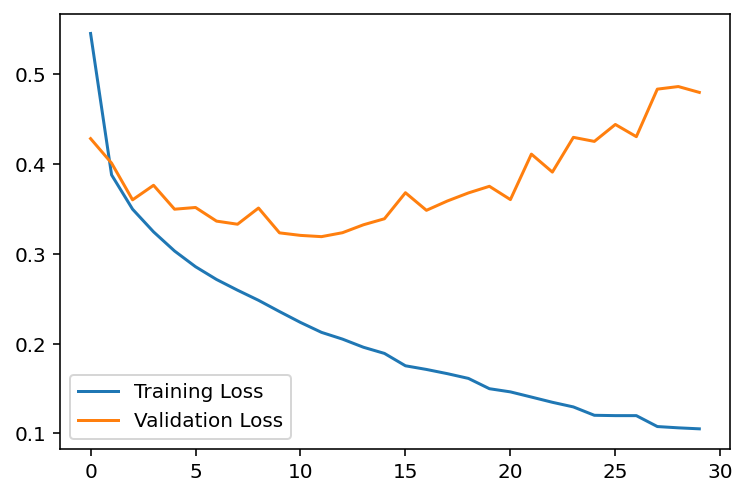

In [16]:
plt.plot(my_MLP.loss_during_training,label='Training Loss')
plt.plot(my_MLP.valid_loss_during_training,label='Validation Loss')
plt.legend()

> **Ejercicio**: Calcule el porcentaje de aciertos en el conjunto de entrenamiento, validación y de test

In [17]:
print(f"Train accuracy {accuracy(trainloader,my_MLP)}")
print(f"Validation accuracy {accuracy(validloader,my_MLP)}")
print(f"Test accuracy {accuracy(testloader,my_MLP)}")

Train accuracy 0.9639781605113636
Validation accuracy 0.8893395390070922
Test accuracy 0.8792794585987261


A la vista de los resultados, el sobreajuste es evidente y comienza a ocurrir en torno a la época 5-10. Este es el punto de parada del entrenamiento para asegurar una mejor generalización del modelo. Esta técnica se conoce como *early stopping*. En modelos muy profundos, en los que el coste de re-entrenamiento es alto, se recomienda guardar los parámetros del modelo cada ciertas épocas y recuperar estos valores para el punto de early stopping adecuado.

> **Ejercicio:** De acuerdo con sus resultados, vuelva a entrenar el modelo para el número correcto de épocas (justo antes de que la pérdida de validación comience a crecer). Compare el porcentaje de aciertos en entrenamiento, validación y test.

In [18]:
my_MLP = MLP_extended2(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=8,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.553456, Validation loss: 0.417468
Epoch 1. Training loss: 0.391139, Validation loss: 0.376088
Epoch 2. Training loss: 0.352424, Validation loss: 0.396854
Epoch 3. Training loss: 0.323571, Validation loss: 0.348227
Epoch 4. Training loss: 0.300532, Validation loss: 0.342205
Epoch 5. Training loss: 0.284423, Validation loss: 0.335080
Epoch 6. Training loss: 0.274231, Validation loss: 0.364931
Epoch 7. Training loss: 0.258267, Validation loss: 0.339136


In [19]:
print(f"Train accuracy {accuracy(trainloader,my_MLP)}")
print(f"Validation accuracy {accuracy(validloader,my_MLP)}")
print(f"Test accuracy {accuracy(testloader,my_MLP)}")

Train accuracy 0.9073153409090909
Validation accuracy 0.8836879432624113
Test accuracy 0.873109076433121


## 3. Regularización con Dropout

El método más común para combatir el sobreajuste (al margen de *early stopping*) es *dropout*, donde cancelamos aleatoriamente algunas unidades ocultas de una determinada capa. Esto obliga a la red a compartir información entre pesos, aumentando su capacidad para generalizar a nuevos datos. Utilizar dropout en PyTorch es sencillo usando el módulo [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).

El siguiente código corresponde a un NN de 2 capas donde usamos dropout en la capa intermedia:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout con probabilidad de borrado 0.2
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) 
        return x

```

Durante el entrenamiento, utilizaremos dropout para evitar el sobreajuste, pero durante la validación/test queremos usar toda la red y, por lo tanto,  debemos desactivar dropout. Para hacer esto, usaremos `self.eval ()`. Esto establece el modelo en modo de evaluación donde la probabilidad de borrado es 0. Puede volver a activar *dropout* configurando el modelo en modo de entrenamiento con `self.train ()` 


> **Ejercicio:**
> - Cree una nueva clase NN que modifique la anterior incorporando un paso de abandono con `p = 0.2` después de cada no linealidad de ReLU.
> - Modifique la clase extendida para establecer `model.eval ()` cuando sea apropiado (no olvide volver a `model.train ()`). 
> - Para este nuevo modelo, representar la evolución de las pérdidas de entrenamiento y validación. Compare con el caso sin dropout. Analice los resultados. ¿Sigue siendo necesaria una parada anticipada? 


In [20]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)   
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output4(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

In [21]:
class MLPdrop_extended(MLPdrop):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,prob)  
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Modo "entrenamiento"
        self.train()
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out,labels)

                running_loss += loss.item()

                loss.backward()
                
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
        
            with torch.no_grad(): 
                
                # Modo "evaluación"
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # Volvemos a modo "entrenamiento"
            self.train()
                    
            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                
        # Finalizado el entrenamiento, dejamos activo el modo "validación"
        
        self.eval()

In [22]:
my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3,prob=0.2)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.641188, Validation loss: 0.435479
Epoch 1. Training loss: 0.455538, Validation loss: 0.414439
Epoch 2. Training loss: 0.411509, Validation loss: 0.384530
Epoch 3. Training loss: 0.386956, Validation loss: 0.384635
Epoch 4. Training loss: 0.368654, Validation loss: 0.365487
Epoch 5. Training loss: 0.352999, Validation loss: 0.358257
Epoch 6. Training loss: 0.340079, Validation loss: 0.338136
Epoch 7. Training loss: 0.327555, Validation loss: 0.346239
Epoch 8. Training loss: 0.317675, Validation loss: 0.339375
Epoch 9. Training loss: 0.309671, Validation loss: 0.331237
Epoch 10. Training loss: 0.302300, Validation loss: 0.372526
Epoch 11. Training loss: 0.300014, Validation loss: 0.330453
Epoch 12. Training loss: 0.288460, Validation loss: 0.326008
Epoch 13. Training loss: 0.284407, Validation loss: 0.325763
Epoch 14. Training loss: 0.274628, Validation loss: 0.316278
Epoch 15. Training loss: 0.273925, Validation loss: 0.317944
Epoch 16. Training loss: 0.265780,

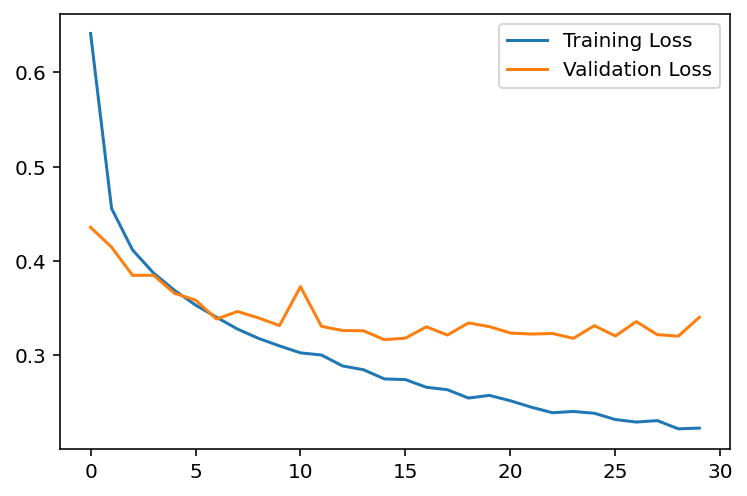

In [23]:
plt.plot(my_MLP_drop.loss_during_training,label='Training Loss')
plt.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

In [24]:
print(f"Train accuracy {accuracy(trainloader,my_MLP_drop)}")
print(f"Validation accuracy {accuracy(validloader,my_MLP_drop)}")
print(f"Test accuracy {accuracy(testloader,my_MLP_drop)}")

Train accuracy 0.9358354048295454
Validation accuracy 0.8883865248226951
Test accuracy 0.8824641719745223
